# Module 3 Project - London Air Quality analysis

1. [Introduction](#intro)
2. [Exploratory Data Analysis](#EDA)
3. [Cleaning](#Cleaning)
4. [Statistical Analysis](#stats)
5. [Discussion](#disc)



<a id='intro'></a>

1. Introduction

    - background about project
    - motivation
    - hypotheses

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats as sms
from functions import APICaller
import seaborn as sns
import matplotlib.pyplot as plt
import requests as req
import time
import scipy.stats as stats
sns.set_style('darkgrid')

import data_cleaning

In [2]:
# first testing of data retrieval from 1st API
location1 = 'LH0'
date = '2008-06-01'
url_extension = '/Daily/MonitoringIndex/SiteCode='
openaq_caller = APICaller(base_url='http://api.erg.kcl.ac.uk/AirQuality', ignore_token=True)

test_resp = openaq_caller.retrieve_one(url_extension,location=location1, date=date)

test_resp

{'DailyAirQualityIndex': {'@MonitoringIndexDate': '2008-06-01',
  '@TimeToLive': '22',
  'LocalAuthority': {'@LocalAuthorityCode': '17',
   '@LocalAuthorityName': 'Hillingdon',
   '@LaCentreLatitude': '51.533411',
   '@LaCentreLongitude': '-0.452568',
   '@LaCentreLatitudeWGS84': '6716195.906043',
   '@LaCentreLongitudeWGS84': '-50379.639309',
   'Site': {'@BulletinDate': '2008-06-01 00:00:00',
    '@SiteCode': 'LH0',
    '@SiteName': 'Hillingdon - Harlington',
    '@SiteType': 'Urban Background',
    '@Latitude': '51.48878',
    '@Longitude': '-0.441627',
    '@LatitudeWGS84': '6708212.94408',
    '@LongitudeWGS84': '-49161.6927606',
    'Species': [{'@SpeciesCode': 'NO2',
      '@SpeciesDescription': 'Nitrogen Dioxide',
      '@AirQualityIndex': '1',
      '@AirQualityBand': 'Low',
      '@IndexSource': 'Measurement'},
     {'@SpeciesCode': 'O3',
      '@SpeciesDescription': 'Ozone',
      '@AirQualityIndex': '3',
      '@AirQualityBand': 'Low',
      '@IndexSource': 'Measurement'}]}

In [4]:
#  retrieve name of species (pollutants);
url_for_species = '/Information/Species/Json'
# species_list = openaq_caller.retrieve_one(url_extension=url_for_species)
#  http://api.erg.kcl.ac.uk/AirQuality/Information/Species/Json
base_url='http://api.erg.kcl.ac.uk/AirQuality'
def retrieve_one(main_url,url_extension,location=None, date=None, date1=None):  
        if date1!=None:
            response = req.get(main_url+url_extension+f'{location}/StartDate={date}/EndDate={date1}/Json').json()
        elif (date!=None and date1==None):
            response = req.get(main_url+url_extension+f'{location}/Date={date}/Json').json()
        else:
            print(base_url+url_extension)
            response = req.get(main_url+url_extension).json()
        return response
    
    
retrieve_one(main_url=base_url, url_extension=url_for_species)

http://api.erg.kcl.ac.uk/AirQuality/Information/Species/Json


{'AirQualitySpecies': {'Species': [{'@SpeciesCode': 'CO',
    '@SpeciesName': 'Carbon Monoxide',
    '@Description': "Carbon Monoxide is a colourless, odourless poisonous gas produced by incomplete, or inefficient, combustion of fuel including 'cold' or badly tuned engines.",
    '@HealthEffect': 'The gas affects the transport of oxygen around the body by the blood. At very high levels, this can lead to a significant reduction in the supply of oxygen to the heart, particularly in people suffering from heart disease.',
    '@Link': 'http://www.londonair.org.uk/LondonAir/guide/WhatIsCO.aspx'},
   {'@SpeciesCode': 'NO2',
    '@SpeciesName': 'Nitrogen Dioxide',
    '@Description': 'Nitrogen oxides are formed during high temperature combustion processes from the oxidation of nitrogen in the air or fuel.',
    '@HealthEffect': 'Nitrogen Dioxide has several health impacts and includes general irritation to the eyes, irritation of the respiratory system and shortness of breath.',
    '@Link': 

In [5]:
url_for_sites = '/MonitoringIndex/GroupName={GroupName}/Json'
url_for_daily_1_date = '/Daily/MonitoringIndex/GroupName={GroupName}/Date=2018/06/03/Json'
# retrieve_one(main_url=base_url, url_extension=url_for_daily_1_date, )

print(req.get(base_url + url_for_sites))

<Response [404]>


In [6]:
def retrieve_many(main_url,url_ext,location_list,species, start_date_list, end_date_list):
        data = []
        counter=0
        for i in range(len(start_date_list)):
            for location in location_list:
                response = req.get(f'{main_url}{url_ext}/SiteCode={location}/SpeciesCode={species}/StartDate={start_date_list[i]}/EndDate={end_date_list[i]}/Json').json()
                data.append(response)
                counter+=1
            data_df = pd.read_json(data)    
            return data_df

In [7]:
response = req.get('http://api.erg.kcl.ac.uk/AirQuality/Data/SiteSpecies/SiteCode=CT3/SpeciesCode=NO2/StartDate=2006/05/01/EndDate=2006/05/02/csv')

print(response)

<Response [404]>


In [8]:
# will set loop to run over multiple dates
base_url='http://api.erg.kcl.ac.uk/AirQuality'
location_list0 = ['LH0','ZR2', 'BL0', 'EN4', 'CT3', 'RI1']
species_code='NO2'
url_data = '/Data/SiteSpecies'
start_dates = ['2006/05/01', '2006/10/01']
end_dates = ['2006/06/01', '2006/11/01']

NO2_LEZ = retrieve_many(main_url=base_url, url_ext = url_data, location_list=location_list0, species=species_code, start_date_list = start_dates, end_date_list = end_dates)

JSONDecodeError: Unexpected UTF-8 BOM (decode using utf-8-sig): line 1 column 1 (char 0)

In [9]:
# API failed to work after many attempts. Might go back to this. Will just use CSV downloaded data for now. 

### Data cleaning

We've downloaded and have processed our data. We've initially selected data for six sites across Inner London for the LEZ testing (hypotheses 2 and 4). 

In [10]:
# check our original retrieved csv for NO2 

df_no2 = pd.read_csv('city_no2.csv')
print(df_no2.shape)
df_no2.head()

(25260, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
0,CT3,NO2,01/01/2006 00:00,37.4,ug m-3,R
1,CT3,NO2,02/01/2006 00:00,39.8,ug m-3,R
2,CT3,NO2,03/01/2006 00:00,57.5,ug m-3,R
3,CT3,NO2,04/01/2006 00:00,51.0,ug m-3,R
4,CT3,NO2,05/01/2006 00:00,50.7,ug m-3,R


In [11]:
# check our original retrieved csv for PM10

df_pm10 = pd.read_csv('city_pm10.csv')
print(df_no2.shape)
df_pm10.tail()

(25260, 6)


,Site,Species,ReadingDateTime,Value,Units,Provisional or Ratified
25255,WM6,PM10,27/10/2019 00:00,20.0,ug/m3,P
25256,WM6,PM10,28/10/2019 00:00,27.0,ug/m3,P
25257,WM6,PM10,29/10/2019 00:00,18.0,ug/m3,P
25258,WM6,PM10,30/10/2019 00:00,30.0,ug/m3,P
25259,WM6,PM10,31/10/2019 00:00,41.0,ug/m3,P


In [13]:
df_no2_clean = data_cleaning.full_clean(input_data = 'city_no2.csv',
                                            date_column = 'ReadingDateTime', 
                                            columns_of_interest = ['Value'],
                                            column_to_drop = 'Provisional or Ratified', 
                                            target_col = ['Year', 'Year'],
                                            values_of_interest = [2017, 2009],
                                            output_file_name = 'clean_data_for_testing')

df_no2_clean.head()

,Site,Species,ReadingDateTime,Value,Units,Year,Month
4018,CT3,NO2,2017-01-01,26.1,ug m-3,2017,1
4019,CT3,NO2,2017-02-01,36.0,ug m-3,2017,2
4020,CT3,NO2,2017-03-01,66.3,ug m-3,2017,3
4021,CT3,NO2,2017-04-01,54.7,ug m-3,2017,4
4022,CT3,NO2,2017-05-01,72.6,ug m-3,2017,5


In [14]:
df_pm10_clean = data_cleaning.full_clean(input_data = 'city_pm10.csv',
                                            date_column = 'ReadingDateTime', 
                                            columns_of_interest = ['Value'],
                                            column_to_drop = 'Provisional or Ratified', 
                                            target_col = ['Year', 'Year'],
                                            values_of_interest = [2017, 2009],
                                            output_file_name = 'clean_data_for_testing')

df_pm10_clean.tail()

,Site,Species,ReadingDateTime,Value,Units,Year,Month
16612,HK6,PM10,2009-12-27,11.6,ug m-3 reference equiv by VCM,2009,12
16613,HK6,PM10,2009-12-28,23.4,ug m-3 reference equiv by VCM,2009,12
16614,HK6,PM10,2009-12-29,20.1,ug m-3 reference equiv by VCM,2009,12
16615,HK6,PM10,2009-12-30,14.8,ug m-3 reference equiv by VCM,2009,12
16616,HK6,PM10,2009-12-31,14.1,ug m-3 reference equiv by VCM,2009,12


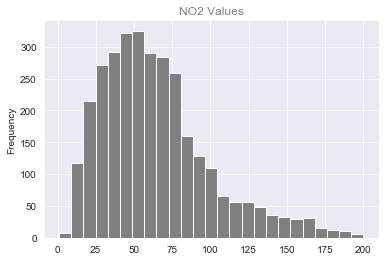

In [15]:
# make a frequency barplot for NO2 for year 2009 and 2017 

df_no2_clean.Value.plot.hist(range=(1, 200), bins=25, color='grey')
plt.title('NO2 Values', color = 'grey')
plt.show()

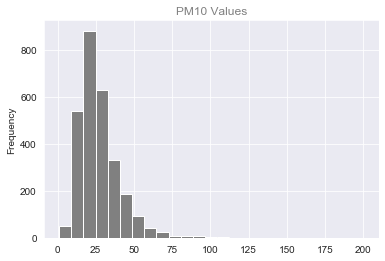

In [16]:
# make a frequency barplot for PM10 for year 2009 and 2017 

df_pm10_clean.Value.plot.hist(range=(1, 200), bins=25, color='grey')
plt.title('PM10 Values', color = 'grey')
plt.show()

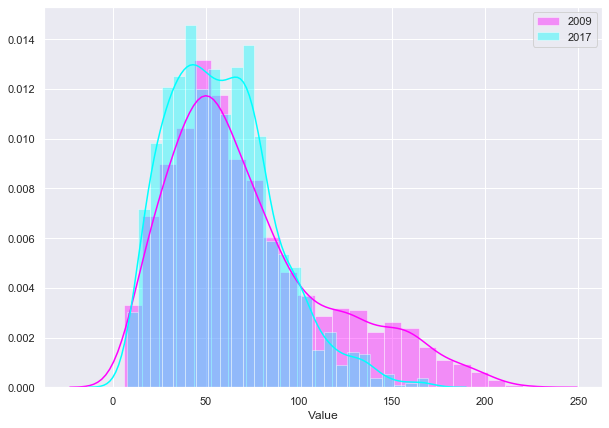

In [17]:
sns.set_color_codes('dark')
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(df_no2_clean.loc[df_no2_clean['Year']==2009]['Value'], color='magenta')
sns.distplot(df_no2_clean.loc[df_no2_clean['Year']==2017]['Value'], color='cyan')
# sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2018]['Value'], color='grey')
plt.legend(labels=['2009', '2017'])

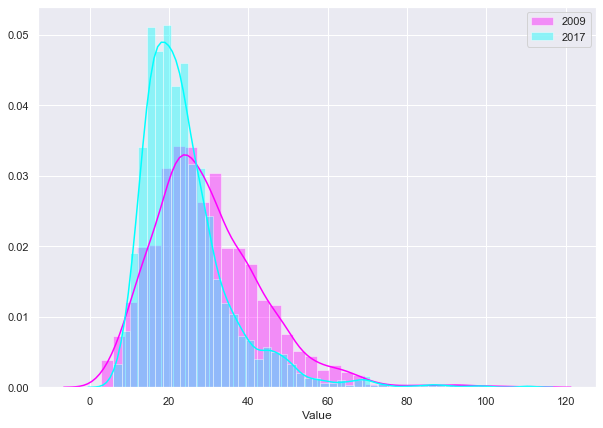

In [18]:
sns.set_color_codes('dark')
sns.set(rc={'figure.figsize':(10,7)})
sns.distplot(df_pm10_clean.loc[df_pm10_clean['Year']==2009]['Value'], color='magenta')
sns.distplot(df_pm10_clean.loc[df_pm10_clean['Year']==2017]['Value'], color='cyan')
# sns.distplot(df_pm10_new.loc[df_pm10_new['Year']==2018]['Value'], color='grey')
plt.legend(labels=['2009', '2017'])

In [ ]:
# Now we make our testing samples below, for May and Oct 2006, 2009, for both the PM10 and the NO2 values. 
pre_lez_no2 = test_df_no2.loc[test_df_no2['Year']==2006]
post_lez_no2 = test_df_no2.loc[test_df_no2['Year']==2009]

pre_lez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2006]
post_lez_pm10 = test_df_pm10.loc[test_df_pm10['Year']==2009]

In [ ]:
sns.distplot(pre_lez_no2.Value,bins=20)

In [ ]:
sns.distplot(pre_lez_pm10.Value,bins=20)

## Statistical Testing

(Mina)

1. The introducton of ULEZ (8th April 2019) decreased the amount of NOx in Zone 1 of Central London by at least 42%. 
[H0] - ULEZ reduced the amount of NOx in Zone 1 by less than 42%.
2. The introduction of ULEZ was at least 25% more effective than the introduction of LEZ (4th February 2008) in reducing NOx levels in Central London.
[H0] - The effect of ULEZ on NOx levels was less than 25% more than the impact of LEZ. 

(Ioana) 
3. The introducton of ULEZ decreased the amount of PM10 in Zone 1 of Central London by at least 33%. 
[H0] - ULEZ reduced the amount of PM10 in Zone 1 by less than 33%.
4. The introduction of ULEZ was at least 25% more effective than the introduction of LEZ in reducing PM10 levels in Central London. 
[H0] - The effect of ULEZ on PM10 levels was less than 25% more than the impact of LEZ. 

Our alpha values are set at 0.05.

In [ ]:
def sample_variance(sample):
    return np.sum([(x - np.mean(sample))**2 for x in sample])/(len(sample)-1)

def pooled_variance(sample1, sample2):
    return ((len(sample1)-1)*sample_variance(sample1) + (len(sample2)-1)*sample_variance(sample2))/(len(sample1) + len(sample2) - 2)


def visualize_t(t_stat, n_control, n_experimental):
    df = len(n_experimental)-1
    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca()
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4,4,200)
    # use stats.t.pdf to get values on the probability density function for the t-distribution
    ys = stats.t.pdf(xs, df, 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkblue')

    # Draw two sided boundary for critical-t
    ax.axvline(x=+t_stat, color='red', linestyle='--', lw=3,label='t-statistic_lower_bound')
    ax.axvline(x=-t_stat, color='purple', linestyle='--', lw=3,label='t-statistic_upper_bound')
    ax.legend()
    plt.show()
    return 

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    # Calculate the pooled threshold as shown earlier
    pooled_var = pooled_variance(group1, group2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d


def welch_t_test(sample1,sample2):
    num = np.mean(sample1)-np.mean(sample2)
    denom = np.sqrt((sample_variance(sample1)**2/len(sample1)) + (sample_variance(sample2)**2/len(sample2)))
    return num/denom
 
def welch_t(sample1, sample2):
    numerator = np.mean(sample1) - np.mean(sample2)   
    denominator = np.sqrt(np.var(sample1)/len(sample1) + np.var(sample2)/len(sample2))
    return np.abs(numerator/denominator)    

def welch_dof(sample1,sample2):
    s1 = np.var(sample1)
    s2 = np.var(sample2)
    n1 = len(sample1)
    n2 = len(sample2)
    
    num = (s1/n1 + s2/n2)**2
    denom = (s1/n1)**2/(n1-1) + (s2/n2)**2/(n2-1)
    return num/denom
              
def p_val(t_stat, df):
    return 1-stats.t.cdf(t_stat,df)

In [ ]:
p_val(welch_t(pre_lez_no2.Value, post_lez_no2.Value), welch_dof(pre_lez_no2.Value, post_lez_no2.Value))

In [ ]:
p_val(welch_t(pre_lez_pm10.Value, post_lez_pm10.Value), welch_dof(pre_lez_pm10.Value, post_lez_pm10.Value))

In [ ]:
stats.ttest_ind(pre_lez_no2.Value, post_lez_no2.Value, equal_var=False)

In [ ]:
stats.ttest_ind(pre_lez_pm10.Value, post_lez_pm10.Value, equal_var=False)

In [ ]:
lez_d_no2 = Cohen_d(pre_lez_no2.Value, post_lez_no2.Value)
print("The effect of LEZ on the levels of NO2 in the Central London: ", lez_d_no2)

In [ ]:
lez_d_pm10 = Cohen_d(pre_lez_pm10.Value, post_lez_pm10.Value)
print("The effect of LEZ on the levels of PM10 in the Central London: ", lez_d_pm10)

Having conducted our statistical significance test for LEZ, we conclude that there was a significant impact on NO2 levels due to LEZ, but our p-value for the PM10 levels was so large that we cannot reject the null hypothesis that LEZ had no impact on PM10. Given that we're trying to compare ULEZ to LEZ impact, we will return to the PM10 levels once we have conducted our tests on the ULEZ dates

In [ ]:
len(pre_ulez_no2)

In [ ]:
len(post_ulez_no2)

In [ ]:
len(pre_ulez_pm10)

In [ ]:
len(post_ulez_pm10)

In [ ]:
pre_ulez_no2.Site.value_counts()

For our pre- and post-ULEZ comparisons we'll be using a different batch of data. 

In [ ]:
city_df_pm10 = pd.read_csv('city_pm10.csv')
city_df_no2 = pd.read_csv('city_no2.csv')

In [ ]:
city_df_pm10.Site.value_counts()

In [ ]:
city_df_no2.Site.value_counts()

In [ ]:
# cleaning the data as before
city_df_pm10.tail()

In [ ]:
len(city_df_pm10)

In [ ]:
len(city_df_no2)

In [ ]:
print(len(city_df_pm10.loc[city_df_pm10.Value.isna()]))
print(len(city_df_no2.loc[city_df_no2.Value.isna()]))

In [ ]:
city_df_pm10 = city_df_pm10.dropna()
city_df_no2 = city_df_no2.dropna()

# city_df_pm10 = city_df_pm10.

city_df_pm10.ReadingDateTime = pd.to_datetime(city_df_pm10.ReadingDateTime)
city_df_no2.ReadingDateTime = pd.to_datetime(city_df_no2.ReadingDateTime)

city_df_pm10['Year'] = city_df_pm10.ReadingDateTime.dt.year
city_df_no2['Year'] = city_df_no2.ReadingDateTime.dt.year

city_df_pm10['Month'] = city_df_pm10.ReadingDateTime.dt.month
city_df_no2['Month'] = city_df_no2.ReadingDateTime.dt.month


In [ ]:
ulez_test_df_no2 = city_df_no2.loc[(city_df_no2.Month == 5)|(city_df_no2.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])
ulez_test_df_pm10 = city_df_pm10.loc[(city_df_pm10.Month == 5)|(city_df_pm10.Month == 10)].drop(columns=['ReadingDateTime','Provisional or Ratified'])

ulez_test_df_no2.tail()

In [ ]:
pre_ulez_no2 = ulez_test_df_no2.loc[ulez_test_df_no2['Year']==2018]
post_ulez_no2 = ulez_test_df_no2.loc[ulez_test_df_no2['Year']==2019]

pre_ulez_pm10 = ulez_test_df_pm10.loc[ulez_test_df_pm10['Year']==2018]
post_ulez_pm10 = ulez_test_df_pm10.loc[ulez_test_df_pm10['Year']==2019]

In [ ]:
stats.ttest_ind(pre_ulez_no2.Value, post_ulez_no2.Value, equal_var=False)

In [ ]:
stats.ttest_ind(pre_ulez_pm10.Value, post_ulez_pm10.Value, equal_var=False)

In [ ]:
ulez_d_no2 = Cohen_d(post_ulez_no2.Value, pre_ulez_no2.Value)
print("The effect of ULEZ on the levels of NO2 in the City of London: ", ulez_d_no2)

In [ ]:
ulez_d_pm10 = Cohen_d(post_ulez_pm10.Value, pre_ulez_pm10.Value)
print("The effect of ULEZ on the levels of PM10 in the City of London: ", ulez_d_pm10)

In [ ]:
sns.distplot(pre_ulez_no2.Value,color='r')
sns.distplot(post_ulez_no2.Value,color='b')

In [ ]:
sns.distplot(pre_ulez_pm10.Value,color='r')
sns.distplot(post_ulez_pm10.Value,color='b')

In [ ]:
# Testing hypothesis nr 2:
print('The impact of ULEZ on NO2 was ', round((ulez_d_no2/lez_d_no2)*100,1),'% more significant than LEZ.')

In [ ]:
# Testing hypothesis nr 4:
print('The impact of ULEZ on PM10 was ', round((ulez_d_pm10/lez_d_pm10)*100,1),'% more significant than LEZ.')

Checkpoint: at the moment, given the data that we have used, we have managed to reject all four null hypotheses and go and to test the alternative hypotheses. 
HOWEVER, we have realized now that our data is not adequate for the Welch's T-test, so we will be re-running our sampling to achieve a more normal distribution.

In [ ]:
print(lez_d_no2)

In [ ]:
print((post_lez_no2.Value.mean()-pre_lez_no2.Value.mean())/ pre_lez_no2.Value.mean())

In [ ]:
print((post_lez_pm10.Value.mean()-pre_lez_pm10.Value.mean())/ pre_lez_pm10.Value.mean())

In [ ]:
print((post_ulez_no2.Value.mean()-pre_ulez_no2.Value.mean())/ pre_ulez_no2.Value.mean())

In [ ]:
print((post_ulez_pm10.Value.mean()-pre_ulez_pm10.Value.mean())/ pre_ulez_pm10.Value.mean())

In [ ]:
len(post_ulez_no2.Value)